In [27]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.optimizers import Adam
from keras.metrics import MeanSquaredError, MeanAbsoluteError, MeanAbsolutePercentageError
from math import sqrt
import numpy as np
from scipy.stats import randint, uniform
from sklearn.model_selection import RandomizedSearchCV
from joblib import load 
import os
from sklearn.preprocessing import MinMaxScaler
import joblib
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import os
import joblib
from sklearn.metrics import mean_squared_error, mean_absolute_error
from keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
import keras_tuner as kt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam

In [28]:
data_for_lstm = pd.read_csv("modeling_data_2.csv")

In [29]:
data_for_lstm.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20431 entries, 0 to 20430
Data columns (total 13 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   County_2                   20431 non-null  int64  
 1   Date                       20431 non-null  object 
 2   Year                       20431 non-null  int64  
 3   Year_sin                   20431 non-null  float64
 4   Year_cos                   20431 non-null  float64
 5   Wholesale_lag_7            20431 non-null  float64
 6   Retail_lag_7               20431 non-null  float64
 7   Wholesale_rolling_mean_7d  20431 non-null  float64
 8   Retail_rolling_mean_7d     20431 non-null  float64
 9   Wholesale_rolling_std_7d   20431 non-null  float64
 10  Retail_rolling_std_7d      20431 non-null  float64
 11  Wholesale                  20431 non-null  float64
 12  Retail                     20431 non-null  float64
dtypes: float64(10), int64(2), object(1)
memory usa

In [30]:
data_for_lstm.isna().sum()

County_2                     0
Date                         0
Year                         0
Year_sin                     0
Year_cos                     0
Wholesale_lag_7              0
Retail_lag_7                 0
Wholesale_rolling_mean_7d    0
Retail_rolling_mean_7d       0
Wholesale_rolling_std_7d     0
Retail_rolling_std_7d        0
Wholesale                    0
Retail                       0
dtype: int64

In [31]:
data_for_lstm = data_for_lstm.drop(columns=['Date'])

In [32]:
# Define target variable - using Wholesale
target = data_for_lstm['Wholesale']

# Define features - excluding target variable
features = data_for_lstm.drop(columns=['Wholesale','Retail'])

# Splitting the data into train and test sets while maintaining temporal order
train_size = int(len(features) * 0.7)
validation_size = int(len(features) * 0.15)
test_size = len(features) - train_size - validation_size

train_features, test_features = features[:train_size], features[train_size:]
train_target, test_target = target[:train_size], target[train_size:]

validation_features, test_features = test_features[:validation_size], test_features[validation_size:]
validation_target, test_target = test_target[:validation_size], test_target[validation_size:]

# Verifying the sizes of each set
(train_features.shape, validation_features.shape, test_features.shape), (train_target.shape, validation_target.shape, test_target.shape)

(((14301, 10), (3064, 10), (3066, 10)), ((14301,), (3064,), (3066,)))

In [33]:
# Automatically detect numerical columns (excluding target columns)
columns_to_normalize = train_features.select_dtypes(include=[np.number]).columns.tolist()

def scale_dataframe(data, columns, scalers=None, fit=False):
    """
    Scale specified columns in the DataFrame using MinMaxScaler.

    Parameters:
    - data (pd.DataFrame): The DataFrame to scale.
    - columns (list): List of columns to scale.
    - scalers (dict): Optional dictionary of existing scalers.
    - fit (bool): Whether to fit the scaler on the data (True for training set, False for others).

    Returns:
    - pd.DataFrame: Scaled DataFrame.
    - dict: Dictionary of scalers used for scaling.
    """
    if scalers is None:
        scalers = {}

    for column in columns:
        if column not in scalers:  # Create new scaler only if not already provided
            scalers[column] = MinMaxScaler()

        if fit:
            # Fit and transform on training data
            data.loc[:, column] = scalers[column].fit_transform(data[[column]])
        else:
            # Only transform validation and test data
            data.loc[:, column] = scalers[column].transform(data[[column]])

    return data, scalers

# Scale the train, validation, and test datasets
train_features, scalers = scale_dataframe(train_features, columns_to_normalize, fit=True)
validation_features, _ = scale_dataframe(validation_features, columns_to_normalize, scalers=scalers, fit=False)
test_features, _ = scale_dataframe(test_features, columns_to_normalize, scalers=scalers, fit=False)

# Ensure the directory for saving scalers exists
scaler_file_path = 'models/scalers.pkl'
os.makedirs(os.path.dirname(scaler_file_path), exist_ok=True)

# Save the scalers dictionary to a file using joblib
joblib.dump(scalers, scaler_file_path)

# Verify the first few rows of the scaled datasets
print(train_features.head())
print(validation_features.head())
print(test_features.head())


   County_2      Year  Year_sin      Year_cos  Wholesale_lag_7  Retail_lag_7  \
0         0  0.000000       0.5  1.000000e+00         0.045851      0.049988   
1         0  0.000000       0.5  1.000000e+00         0.045851      0.049988   
2         0  0.000000       0.5  1.000000e+00         0.045851      0.049988   
3         0  0.000000       0.5  1.000000e+00         0.045851      0.049988   
4         0  0.333333       1.0  4.440892e-16         0.045851      0.049988   

   Wholesale_rolling_mean_7d  Retail_rolling_mean_7d  \
0                   0.115639                0.065038   
1                   0.120265                0.065038   
2                   0.126432                0.065038   
3                   0.136465                0.067085   
4                   0.146652                0.069950   

   Wholesale_rolling_std_7d  Retail_rolling_std_7d  
0                  0.006547               0.000000  
1                  0.006547               0.000000  
2                  0.01

## Model 1

In [34]:
# Reshaping input data for LSTM [samples, time steps, features]
# Assuming a time step of 1 for simplicity in this initial model
train_X = train_features.values.reshape((train_features.shape[0], 1, train_features.shape[1]))
validation_X = validation_features.values.reshape((validation_features.shape[0], 1, validation_features.shape[1]))
test_X = test_features.values.reshape((test_features.shape[0], 1, test_features.shape[1]))

In [35]:
# Initial LSTM Model
model_1 = Sequential()
model_1.add(LSTM(30, activation='tanh', input_shape=(1, train_features.shape[1])))
model_1.add(Dense(1))

# Compiling the model
model_1.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

# Summary of the model
model_1.summary()

# Training the model
history_1 = model_1.fit(train_X, train_target, epochs=10, batch_size=32, validation_data=(validation_X, validation_target), verbose=2)


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 30)                4920      
                                                                 
 dense_2 (Dense)             (None, 1)                 31        
                                                                 
Total params: 4951 (19.34 KB)
Trainable params: 4951 (19.34 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/10
447/447 - 8s - loss: 2550.4780 - val_loss: 2727.8669 - 8s/epoch - 17ms/step
Epoch 2/10
447/447 - 2s - loss: 1358.3921 - val_loss: 1790.3599 - 2s/epoch - 4ms/step
Epoch 3/10
447/447 - 2s - loss: 848.3112 - val_loss: 1373.8237 - 2s/epoch - 4ms/step
Epoch 4/10
447/447 - 2s - loss: 642.5101 - val_loss: 1180.2334 - 2s/epoch - 3ms/step
Epoch 5/10
447/447 - 2s - loss: 558.8250 - val_loss: 1081.0570 - 2s/epoch

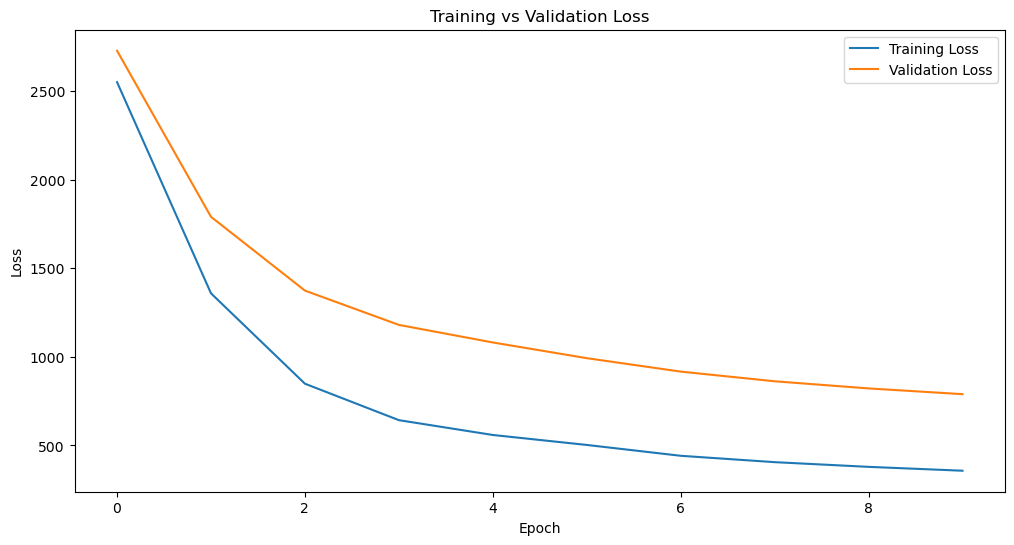

In [36]:
# Plot training & validation loss values
plt.figure(figsize=(12, 6))
plt.plot(history_1.history['loss'], label='Training Loss')
plt.plot(history_1.history['val_loss'], label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()

In [37]:
test_predictions = model_1.predict(test_X)

# RMSE (Root Mean Squared Error)
mse_metric = MeanSquaredError()
mse_metric.update_state(test_target, test_predictions)
rmse = sqrt(mse_metric.result().numpy())

# MAE (Mean Absolute Error)
mae_metric = MeanAbsoluteError()
mae_metric.update_state(test_target, test_predictions)
mae = mae_metric.result().numpy()

# MAPE (Mean Absolute Percentage Error)
mape_metric = MeanAbsolutePercentageError()
mape_metric.update_state(test_target, test_predictions)
mape = mape_metric.result().numpy()

rmse, mae, mape

96/96 [==============================] - 1s 3ms/step


(24.443904261930136, 10.157537, 1089.8176)

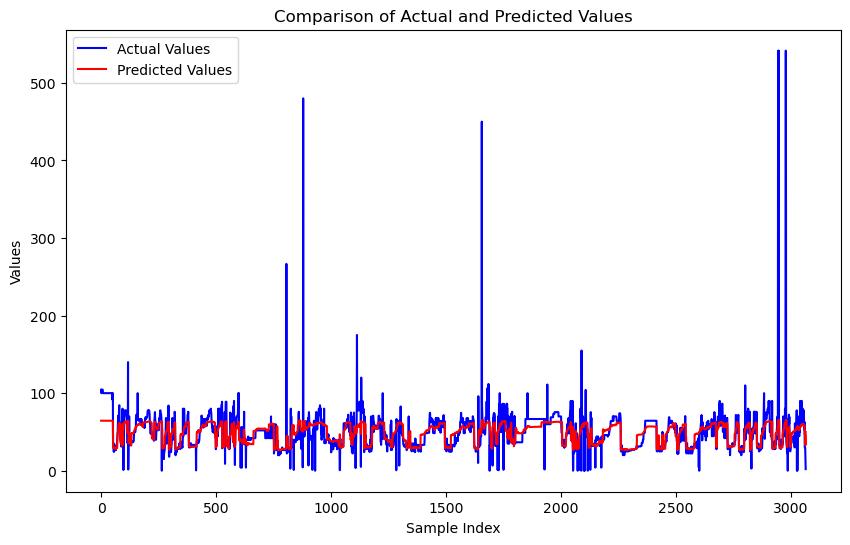

In [38]:
# Converting predictions and actual values to a compatible format for plotting
# Convert the Pandas Series to NumPy array before flattening
actual = np.array(test_target).flatten()
predicted = np.array(test_predictions).flatten()

# Creating the plot
plt.figure(figsize=(10, 6))
plt.plot(actual, label='Actual Values', color='blue')
plt.plot(predicted, label='Predicted Values', color='red')
plt.title('Comparison of Actual and Predicted Values')
plt.xlabel('Sample Index')
plt.ylabel('Values')
plt.legend()
plt.show()

In [39]:
# Reshape predictions to 1D array for easier comparison
y_pred = test_predictions.flatten()

# Compare predictions with actual values
print("Predicted Prices:", y_pred[:5])
print("Actual Prices:", test_target[:5])

mse = mean_squared_error(test_target, y_pred)
mae = mean_absolute_error(test_target, y_pred)

print(f"Mean Squared Error (MSE): {mse}")
print(f"Mean Absolute Error (MAE): {mae}")

Predicted Prices: [64.4978   64.50213  64.53991  64.482285 64.534454]
Actual Prices: 17365    104.44
17366    100.00
17367    100.00
17368    104.44
17369    104.44
Name: Wholesale, dtype: float64
Mean Squared Error (MSE): 597.504521759808
Mean Absolute Error (MAE): 10.157537073935393


## more complex model


In [40]:
# Parameters
n_timesteps = 7  # Using a 7-day window
n_features = train_features.shape[1]  # Number of features

# Reshape training data using a sliding window
train_X = np.array([
    train_features.values[i:i + n_timesteps] 
    for i in range(len(train_features) - n_timesteps)
])

validation_X = np.array([
    validation_features.values[i:i + n_timesteps] 
    for i in range(len(validation_features) - n_timesteps)
])

test_X = np.array([
    test_features.values[i:i + n_timesteps] 
    for i in range(len(test_features) - n_timesteps)
])

# Adjust target (y) to match the sequence length reduction
train_y = train_target.values[n_timesteps:]
validation_y = validation_target.values[n_timesteps:]
test_y = test_target.values[n_timesteps:]

# Print shapes to verify
print(f"train_X shape: {train_X.shape}")  # (samples, 7, 10)
print(f"train_y shape: {train_y.shape}")  # (samples,)
print(f"validation_X shape: {validation_X.shape}")  
print(f"test_X shape: {test_X.shape}")  


train_X shape: (14294, 7, 10)
train_y shape: (14294,)
validation_X shape: (3057, 7, 10)
test_X shape: (3059, 7, 10)


In [41]:
n_timesteps = 7  # Use last 7 days as input window (can tweak if needed)
n_features = train_X.shape[2]  # Number of features after preprocessing

# Define the LSTM model
model_2 = Sequential()

# First LSTM layer with return_sequences=True to pass the sequence to the next LSTM layer
model_2.add(LSTM(64, return_sequences=True, input_shape=(n_timesteps, n_features)))
model_2.add(Dropout(0.2))  # Dropout to reduce overfitting

# Second LSTM layer, return_sequences=False because this is the last LSTM layer
model_2.add(LSTM(32))
model_2.add(Dropout(0.2))

# Dense layer to output a single value (Wholesale or Retail)
model_2.add(Dense(1))

# Compile the model
model_2.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

# Display the model summary
model_2.summary()

# Train the model 
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1, min_lr=1e-6)

history_2 = model_2.fit(train_X, train_y, validation_data=(validation_X, validation_y), epochs=100, batch_size=32, callbacks=[early_stopping, lr_scheduler])

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_5 (LSTM)               (None, 7, 64)             19200     
                                                                 
 dropout_4 (Dropout)         (None, 7, 64)             0         
                                                                 
 lstm_6 (LSTM)               (None, 32)                12416     
                                                                 
 dropout_5 (Dropout)         (None, 32)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                 33        
                                                                 
Total params: 31649 (123.63 KB)
Trainable params: 31649 (123.63 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/100
447/

In [42]:
def visualize_training_results(results):
    history = results.history
    plt.figure()
    plt.plot(history['val_loss'])
    plt.plot(history['loss'])
    plt.legend(['val_loss', 'loss'])
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show()
    
    plt.figure()
    plt.plot(history['val_mae'])
    plt.plot(history['mae'])
    plt.legend(['val_acc', 'acc'])
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.show()

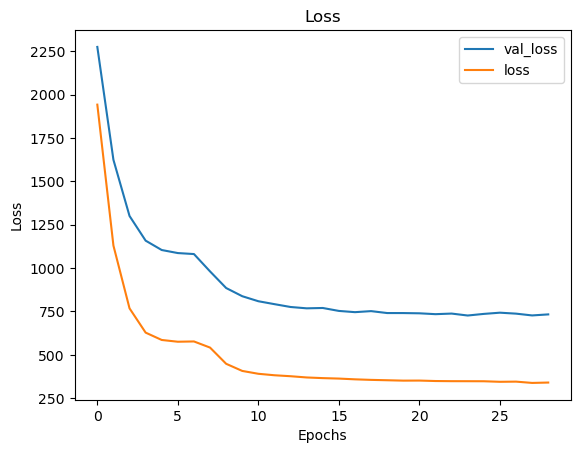

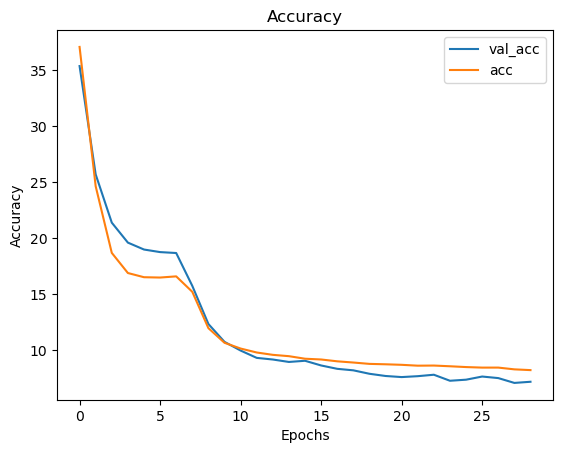

In [43]:
visualize_training_results(history_2)

In [44]:
# Make predictions on the test data
y_pred = model_2.predict(test_X)

# Reshape predictions to 1D array for easier comparison
y_pred = y_pred.flatten()

# Compare predictions with actual values
print("Predicted Prices:", y_pred[:5])
print("Actual Prices:", test_y[:5])


mse = mean_squared_error(test_y, y_pred)
mae = mean_absolute_error(test_y, y_pred)

print(f"Mean Squared Error (MSE): {mse}")
print(f"Mean Absolute Error (MAE): {mae}")


96/96 [==============================] - 4s 12ms/step
Predicted Prices: [80.262856 80.266716 80.26412  80.26026  80.25962 ]
Actual Prices: [104.44 100.   100.   100.   100.  ]
Mean Squared Error (MSE): 584.6145604461367
Mean Absolute Error (MAE): 8.86337801516964


the model is doing better but it's not the best. We can try to improve the model by tuning the hyperparameters


## model 3


#### **Challenges Identified:**
1. **Model 1**:  
   - This model outputs slightly better predictions, but the values are off (e.g., predicted prices around `64` vs. `100+`).  
   - Training might be too short, and the input shape (1 timestep) may not allow the model to learn time dependencies effectively.
2. **Model 2**:  
   - Model architecture seems reasonable, but predicted values are tiny (e.g., `-0.04`).  
   - This suggests a learning issue or data scaling mismatch.




#### **Explanation of Key Improvements:**

1. **Batch Normalization:**  
   - This helps stabilize training by normalizing inputs to each LSTM layer. It can prevent exploding/vanishing gradients.

2. **Dropout Regularization:**  
   - Dropout is kept to reduce overfitting, but carefully balanced.

3. **Adequate Epochs:**  
   - Training with 50 epochs initially and stopping early if performance plateaus.

4. **ReduceLROnPlateau:**  
   - Reduces the learning rate if the model stops improving, giving it more time to learn.

5. **Input Shape Tweaks:**  
   - We now use a **window size of 7 timesteps** for better learning of trends over time (instead of just 1 timestep).


### **Expected Improvements:**


1. **More Accurate Predictions:**  
   - The model should now capture time dependencies better and produce values closer to actual prices.

2. **Better Learning Stability:**  
   - Batch normalization, appropriate dropout, and learning rate scheduling will ensure smooth training.

3. **Improved Generalization:**  
   - Early stopping and proper scaling will prevent overfitting and ensure the model generalizes to new data.


In [45]:
# Parameters
n_timesteps = 7  # Using a 7-day window
n_features = train_features.shape[1]  # Number of features

# Reshape training data using a sliding window
train_X = np.array([
    train_features.values[i:i + n_timesteps] 
    for i in range(len(train_features) - n_timesteps)
])

validation_X = np.array([
    validation_features.values[i:i + n_timesteps] 
    for i in range(len(validation_features) - n_timesteps)
])

test_X = np.array([
    test_features.values[i:i + n_timesteps] 
    for i in range(len(test_features) - n_timesteps)
])

# Adjust target (y) to match the sequence length reduction
train_y = train_target.values[n_timesteps:].reshape(-1, 1)
validation_y = validation_target.values[n_timesteps:].reshape(-1, 1)
test_y = test_target.values[n_timesteps:].reshape(-1, 1)

# Print shapes to verify
print(f"train_X shape: {train_X.shape}")        # (samples, 7, n_features)
print(f"train_y shape: {train_y.shape}")        # (samples, 1)
print(f"validation_X shape: {validation_X.shape}")  
print(f"validation_y shape: {validation_y.shape}") 
print(f"test_X shape: {test_X.shape}")         
print(f"test_y shape: {test_y.shape}") 


train_X shape: (14294, 7, 10)
train_y shape: (14294, 1)
validation_X shape: (3057, 7, 10)
validation_y shape: (3057, 1)
test_X shape: (3059, 7, 10)
test_y shape: (3059, 1)


In [46]:
# Define the LSTM model architecture
model_3 = Sequential()

# First LSTM layer with BatchNormalization to improve learning stability
model_3.add(LSTM(64, return_sequences=True, input_shape=(7, train_X.shape[2])))
model_3.add(BatchNormalization())
model_3.add(Dropout(0.2))

# Second LSTM layer
model_3.add(LSTM(32, return_sequences=False))
model_3.add(BatchNormalization())
model_3.add(Dropout(0.2))

# Output layer with a single neuron for Wholesale/Retail price prediction
model_3.add(Dense(1))

# Compile the model
model_3.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error', metrics=['mae'])

# Display the model summary
model_3.summary()

# Callbacks for early stopping and learning rate reduction
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1, min_lr=1e-6)

# Train the model
history_3 = model_3.fit(
    train_X, train_y,
    validation_data=(validation_X, validation_y),
    epochs=50,  # Start with 50 epochs and increase if necessary
    batch_size=32,
    callbacks=[early_stopping, lr_scheduler],
    verbose=2
)


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_7 (LSTM)               (None, 7, 64)             19200     
                                                                 
 batch_normalization_4 (Bat  (None, 7, 64)             256       
 chNormalization)                                                
                                                                 
 dropout_6 (Dropout)         (None, 7, 64)             0         
                                                                 
 lstm_8 (LSTM)               (None, 32)                12416     
                                                                 
 batch_normalization_5 (Bat  (None, 32)                128       
 chNormalization)                                                
                                                                 
 dropout_7 (Dropout)         (None, 32)               

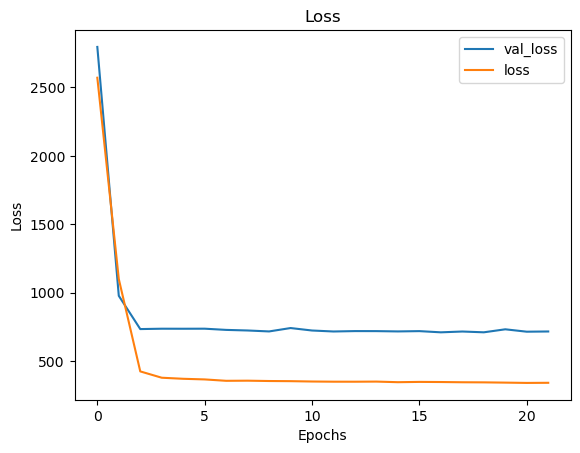

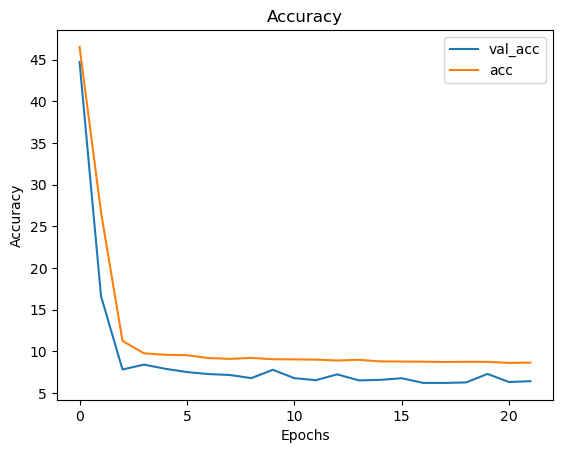

In [47]:
visualize_training_results(history_3)

In [48]:
# Make predictions on the test data
y_pred = model_3.predict(test_X)

# Reshape predictions to 1D array for easier comparison
y_pred = y_pred.flatten()

# Compare predictions with actual values
print("Predicted Prices:", y_pred[:5])
print("Actual Prices:", test_y[:5])

# Optionally calculate and display evaluation metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error

mse = mean_squared_error(test_y, y_pred)
mae = mean_absolute_error(test_y, y_pred)

print(f"Mean Squared Error (MSE): {mse}")
print(f"Mean Absolute Error (MAE): {mae}")


96/96 [==============================] - 5s 14ms/step
Predicted Prices: [98.916985 98.84422  98.59676  98.51463  98.445656]
Actual Prices: [[104.44]
 [100.  ]
 [100.  ]
 [100.  ]
 [100.  ]]
Mean Squared Error (MSE): 564.9964348809743
Mean Absolute Error (MAE): 7.846591461590672


this is so much better. The model isn't too simple or complicated for our data. It's still not perfect so let us tune it ie play around with the parameters


## Model Tuning

Great! Now that we have a working model, let's walk through hyperparameter tuning systematically to improve its performance. The goal is to find the best set of hyperparameters, ensuring the model generalizes well to unseen data.

#### 1. Key Hyperparameters to Tune
Here are the most impactful hyperparameters for the model:

- Number of LSTM units: Try 32, 64, 128 units per LSTM layer.
- Batch size: Common values are 16, 32, 64.
- Learning rate: Try 0.001, 0.0005, 0.0001 for Adam optimizer.
- Dropout rate: Experiment with 0.1 to 0.4 to prevent overfitting.
- Epochs: Start small, around 50 epochs, but increase if necessary.


#### 2. GridSearchCV Using Keras Tuner


In [49]:
# Define the model builder function for Keras Tuner
def model_builder(hp):
    model = Sequential()

    # Tune the number of units in the first LSTM layer
    hp_units_1 = hp.Int('units_1', min_value=32, max_value=128, step=32)
    model.add(LSTM(hp_units_1, return_sequences=True, input_shape=(7, train_X.shape[2])))
    model.add(BatchNormalization())
    model.add(Dropout(hp.Float('dropout_1', 0.1, 0.4, step=0.1)))

    # Tune the number of units in the second LSTM layer
    hp_units_2 = hp.Int('units_2', min_value=32, max_value=64, step=32)
    model.add(LSTM(hp_units_2))
    model.add(BatchNormalization())
    model.add(Dropout(hp.Float('dropout_2', 0.1, 0.4, step=0.1)))

    # Output layer
    model.add(Dense(1))

    # Tune the learning rate of the optimizer
    hp_learning_rate = hp.Choice('learning_rate', [1e-3, 5e-4, 1e-4])
    optimizer = Adam(learning_rate=hp_learning_rate)

    # Compile the model
    model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae'])

    return model

# Instantiate a tuner with Hyperband search
tuner = kt.Hyperband(
    model_builder,
    objective='val_loss',
    max_epochs=50,
    factor=3,
    directory='my_tuning_dir',
    project_name='lstm_hyperparameter_tuning'
)

# Early stopping callback to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Perform the hyperparameter search
tuner.search(
    train_X, train_y,
    validation_data=(validation_X, validation_y),
    callbacks=[early_stopping],
    batch_size=32,
    verbose=2
)

# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"Optimal Units (Layer 1): {best_hps.get('units_1')}")
print(f"Optimal Units (Layer 2): {best_hps.get('units_2')}")
print(f"Optimal Dropout (Layer 1): {best_hps.get('dropout_1')}")
print(f"Optimal Dropout (Layer 2): {best_hps.get('dropout_2')}")
print(f"Optimal Learning Rate: {best_hps.get('learning_rate')}")


Reloading Tuner from my_tuning_dir\lstm_hyperparameter_tuning\tuner0.json
Optimal Units (Layer 1): 32
Optimal Units (Layer 2): 64
Optimal Dropout (Layer 1): 0.2
Optimal Dropout (Layer 2): 0.30000000000000004
Optimal Learning Rate: 0.0005


In [50]:
# Build the model with the best hyperparameters
final_model = tuner.hypermodel.build(best_hps)

# Train the model with optimal hyperparameters
final_history = final_model.fit(
    train_X, train_y,
    validation_data=(validation_X, validation_y),
    epochs=50,
    batch_size=32,
    callbacks=[early_stopping],
    verbose=2
)

# Evaluate the model
loss, mae = final_model.evaluate(test_X, test_y)
print(f"Test Loss: {loss}, Test MAE: {mae}")


Epoch 1/50
447/447 - 27s - loss: 2788.0742 - mae: 48.7016 - val_loss: 3305.6294 - val_mae: 49.7094 - 27s/epoch - 60ms/step
Epoch 2/50
447/447 - 8s - loss: 1883.8147 - mae: 38.7843 - val_loss: 1800.0128 - val_mae: 32.5985 - 8s/epoch - 18ms/step
Epoch 3/50
447/447 - 8s - loss: 854.8206 - mae: 22.2138 - val_loss: 967.6870 - val_mae: 16.1570 - 8s/epoch - 18ms/step
Epoch 4/50
447/447 - 9s - loss: 444.4316 - mae: 11.8313 - val_loss: 753.3292 - val_mae: 8.1614 - 9s/epoch - 19ms/step
Epoch 5/50
447/447 - 8s - loss: 386.5661 - mae: 10.1327 - val_loss: 753.9868 - val_mae: 8.5294 - 8s/epoch - 17ms/step
Epoch 6/50
447/447 - 8s - loss: 377.3326 - mae: 9.9431 - val_loss: 733.8895 - val_mae: 7.6055 - 8s/epoch - 18ms/step
Epoch 7/50
447/447 - 7s - loss: 380.7144 - mae: 9.9698 - val_loss: 730.8955 - val_mae: 7.4127 - 7s/epoch - 15ms/step
Epoch 8/50
447/447 - 7s - loss: 374.1646 - mae: 9.7267 - val_loss: 725.6705 - val_mae: 7.5541 - 7s/epoch - 16ms/step
Epoch 9/50
447/447 - 7s - loss: 374.6196 - mae: 9.

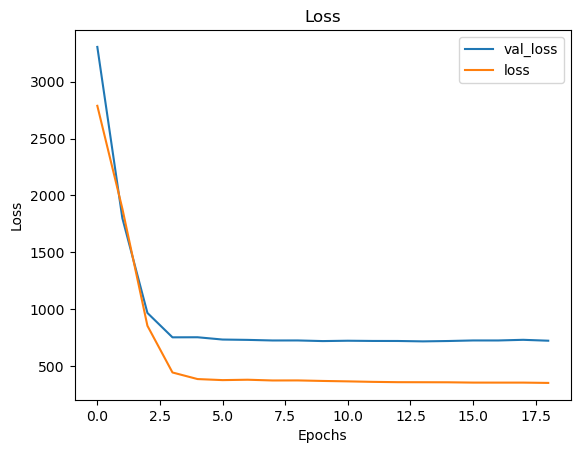

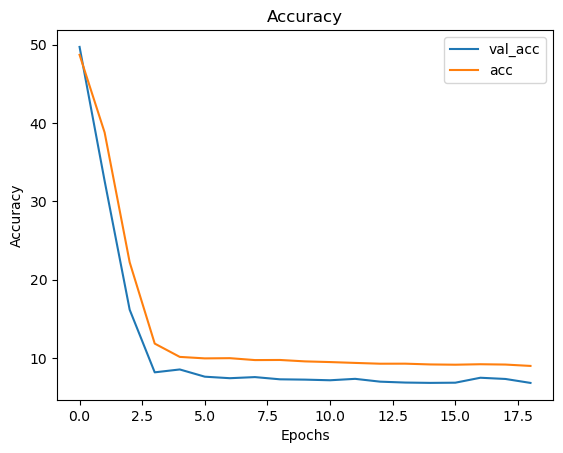

In [51]:
visualize_training_results(final_history)

In [52]:
# Make predictions on the test data
y_pred = final_model.predict(test_X)

# Reshape predictions to 1D array for easier comparison
y_pred = y_pred.flatten()

# Compare predictions with actual values
print("Predicted Prices:", y_pred[:5])
print("Actual Prices:", test_y[:5])

96/96 [==============================] - 3s 6ms/step
Predicted Prices: [95.287994 95.30314  95.17015  95.14517  94.91236 ]
Actual Prices: [[104.44]
 [100.  ]
 [100.  ]
 [100.  ]
 [100.  ]]


In [ ]:
print(classification_report(test_y, y_pred))

In [53]:
final_model.save('../models/final_model.h5')

c:\Users\Hp\anaconda3\envs\env_2\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
